In [179]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import qp
from rail.core.data import DATA_STORE
from rail.utils.catalog_utils import RomanRubinCatalogConfig
DS = DATA_STORE()

In [180]:
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot

Change this to be the root of the current PZ working area

In [181]:
#pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'
pz_dir = '/Users/echarles/pz'

In [182]:
d = tables_io.read(f"{pz_dir}/data/on_sky/dp1_v29.0.0_gold_all.hdf5")
pz = qp.read(f"{pz_dir}/projects/dp1/data/gold_baseline/dp1_all/output_estimate_knn.hdf5")

In [183]:
#train = tables_io.sliceObj(d, slice(0, -1, 10))
train = d 
band_names = raruma_util.make_band_names('{band}_gaap1p0Mag', 'ugrizy')
mags = raruma_util.extract_data_to_2d_array(train,band_names)
mask = np.sum(np.isfinite(mags), axis=1) == 6
colors = raruma_util.adjacent_band_colors(mags)

In [184]:
good_mask  = np.bitwise_and(
    np.bitwise_and(
        train['i_psfMagErr'] < 0.1,
        train['g_psfMagErr'] < 0.1,
    ),
    np.bitwise_and(
        train['r_psfMagErr'] < 0.1,
        train['z_psfMagErr'] < 0.1,
    ),
)


In [185]:
train

OrderedDict([('coord_dec',
              array([  7.38425879,   7.38450465,   7.38460209, ..., -24.54657844,
                     -24.54598465, -24.67878623], shape=(686334,))),
             ('coord_ra',
              array([37.69162292, 37.82590293, 37.73598692, ..., 95.2104274 ,
                     95.13642155, 95.26712369], shape=(686334,))),
             ('g_cModelMag',
              array([24.47764 , 24.323572, 23.970366, ..., 24.933435, 25.185125,
                     25.495403], shape=(686334,), dtype=float32)),
             ('g_cModelMagErr',
              array([0.09967942, 0.12288654, 0.10592858, ..., 0.14042224, 0.13217325,
                     0.12902178], shape=(686334,))),
             ('g_gaap1p0Mag',
              array([24.495476, 24.426447, 24.406008, ..., 25.185322, 25.177244,
                     25.40836 ], shape=(686334,), dtype=float32)),
             ('g_gaap1p0MagErr',
              array([0.10725014, 0.118917  , 0.11144869, ..., 0.17281482, 0.1473851 ,
      

In [186]:
fluxes = raruma_util.mags_to_fluxes(mags, 31.4)

In [187]:
fluxes = np.nan_to_num(fluxes, 200).clip(200, np.inf)

In [188]:
pz_mode = pz.ancil['zmode']

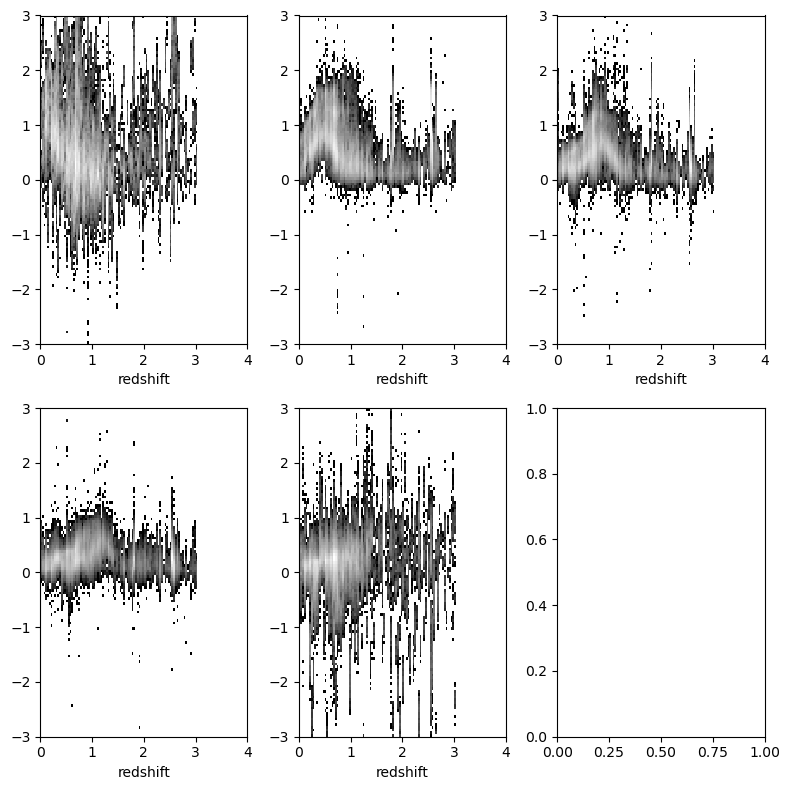

In [189]:
_ = raruma_plot.plot_colors_v_redshifts_with_templates(np.squeeze(pz_mode[good_mask]), colors[good_mask])

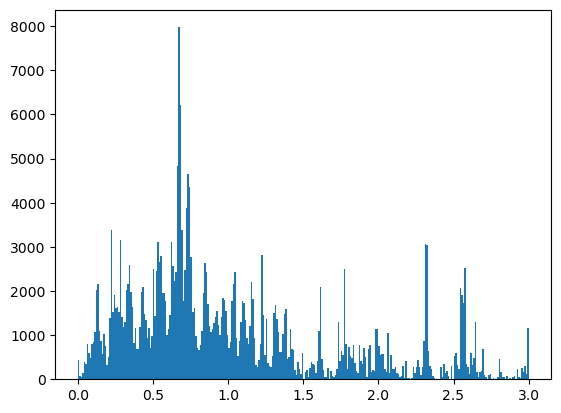

In [190]:
_ = plt.hist(pz_mode[mask], bins=np.linspace(0., 3., 301))

In [191]:
fluxes =  np.nan_to_num(fluxes, 200).clip(200, np.inf)
total_fluxes = fluxes[good_mask].sum(axis=1)

In [192]:
n_obj = len(total_fluxes)

In [193]:
good_mask.size

686334

In [194]:
picks = np.random.randint(n_obj, size=(n_obj))

In [195]:
pick_fluxes = fluxes[picks]

In [196]:
fluxes

array([[ 200.     ,  577.84265, 1111.1045 , 1193.6392 , 1569.7994 ,
         200.     ],
       [ 200.     ,  615.7736 , 1386.0099 , 3814.7092 , 6508.4814 ,
         200.     ],
       [ 200.     ,  627.4754 , 1854.1143 , 2806.387  , 2707.4038 ,
         200.     ],
       ...,
       [ 200.     ,  306.10547,  646.7244 , 1235.2867 , 1408.3674 ,
         680.33923],
       [ 200.     ,  308.3913 ,  893.1255 , 2026.1902 , 2558.0928 ,
        4056.2412 ],
       [ 273.07858,  249.26198,  445.82672,  338.3638 ,  677.0746 ,
         200.     ]], shape=(686334, 6), dtype=float32)

In [197]:
pick_totals = pick_fluxes.sum(axis=1)

In [198]:
pick_weights = total_fluxes / pick_totals

In [199]:
pick_weights

array([0.42247105, 1.2899678 , 3.7621882 , ..., 1.9186168 , 1.3203006 ,
       2.4173436 ], shape=(205557,), dtype=float32)

In [200]:
contamination = (pick_fluxes.T*(pick_weights*0.01)).T

In [201]:
new_fluxes = fluxes[good_mask] + contamination

In [202]:
new_fluxes / fluxes[good_mask]

array([[1.0042247, 1.0218468, 1.0124341, 1.0091525, 1.0085562, 1.0042247],
       [1.0128998, 1.0085934, 1.0097543, 1.0087091, 1.0113776, 1.0128998],
       [1.037622 , 1.0155226, 1.0093797, 1.0088217, 1.0080347, 1.037622 ],
       ...,
       [1.008181 , 1.003511 , 1.0016469, 1.0073699, 1.0122873, 1.0207821],
       [1.0045787, 1.0095128, 1.010567 , 1.0099514, 1.0113544, 1.013203 ],
       [1.0047957, 1.0086915, 1.0128344, 1.0093981, 1.0103347, 1.0241734]],
      shape=(205557, 6), dtype=float32)

In [203]:
(new_fluxes.sum(axis=1) / fluxes[good_mask].sum(axis=1))

array([1.01     , 1.01     , 1.01     , ..., 1.0100001, 1.01     ,
       1.01     ], shape=(205557,), dtype=float32)

In [204]:
new_mags = np.where(np.isfinite(mags[good_mask]), raruma_util.fluxes_to_mags(new_fluxes, 31.4), np.nan)

In [205]:
mags[good_mask] - new_mags

array([[       nan, 0.0234642 , 0.01341629, 0.00989342, 0.00925064,
               nan],
       [       nan, 0.0092907 , 0.0105381 , 0.00941467, 0.01228333,
               nan],
       [       nan, 0.01672363, 0.01013565, 0.00953674, 0.00868797,
               nan],
       ...,
       [0.00884628, 0.00380516, 0.00178719, 0.00797272, 0.01325989,
        0.02233315],
       [0.00495911, 0.0102787 , 0.01141357, 0.01074982, 0.01225853,
               nan],
       [0.00519562, 0.0093956 , 0.01384544, 0.01015472, 0.01116371,
               nan]], shape=(205557, 6), dtype=float32)

In [206]:
diff_mags = mags[good_mask] - new_mags

In [207]:
new_colors = raruma_util.adjacent_band_colors(new_mags)
colors = raruma_util.adjacent_band_colors(mags)

In [208]:
diff_colors = new_colors - colors[good_mask]

In [209]:
diff_colors

array([[        nan, -0.01004791, -0.00352287, -0.00064278,         nan],
       [        nan,  0.00124741, -0.00112343,  0.00286865,         nan],
       [        nan, -0.00658798, -0.00059891, -0.00084877,         nan],
       ...,
       [-0.00504112, -0.00201797,  0.00618553,  0.00528717,  0.00907326],
       [ 0.0053196 ,  0.00113487, -0.00066376,  0.00150871,         nan],
       [ 0.00419998,  0.00444984, -0.00369072,  0.00100899,         nan]],
      shape=(205557, 5), dtype=float32)

In [210]:
import corner

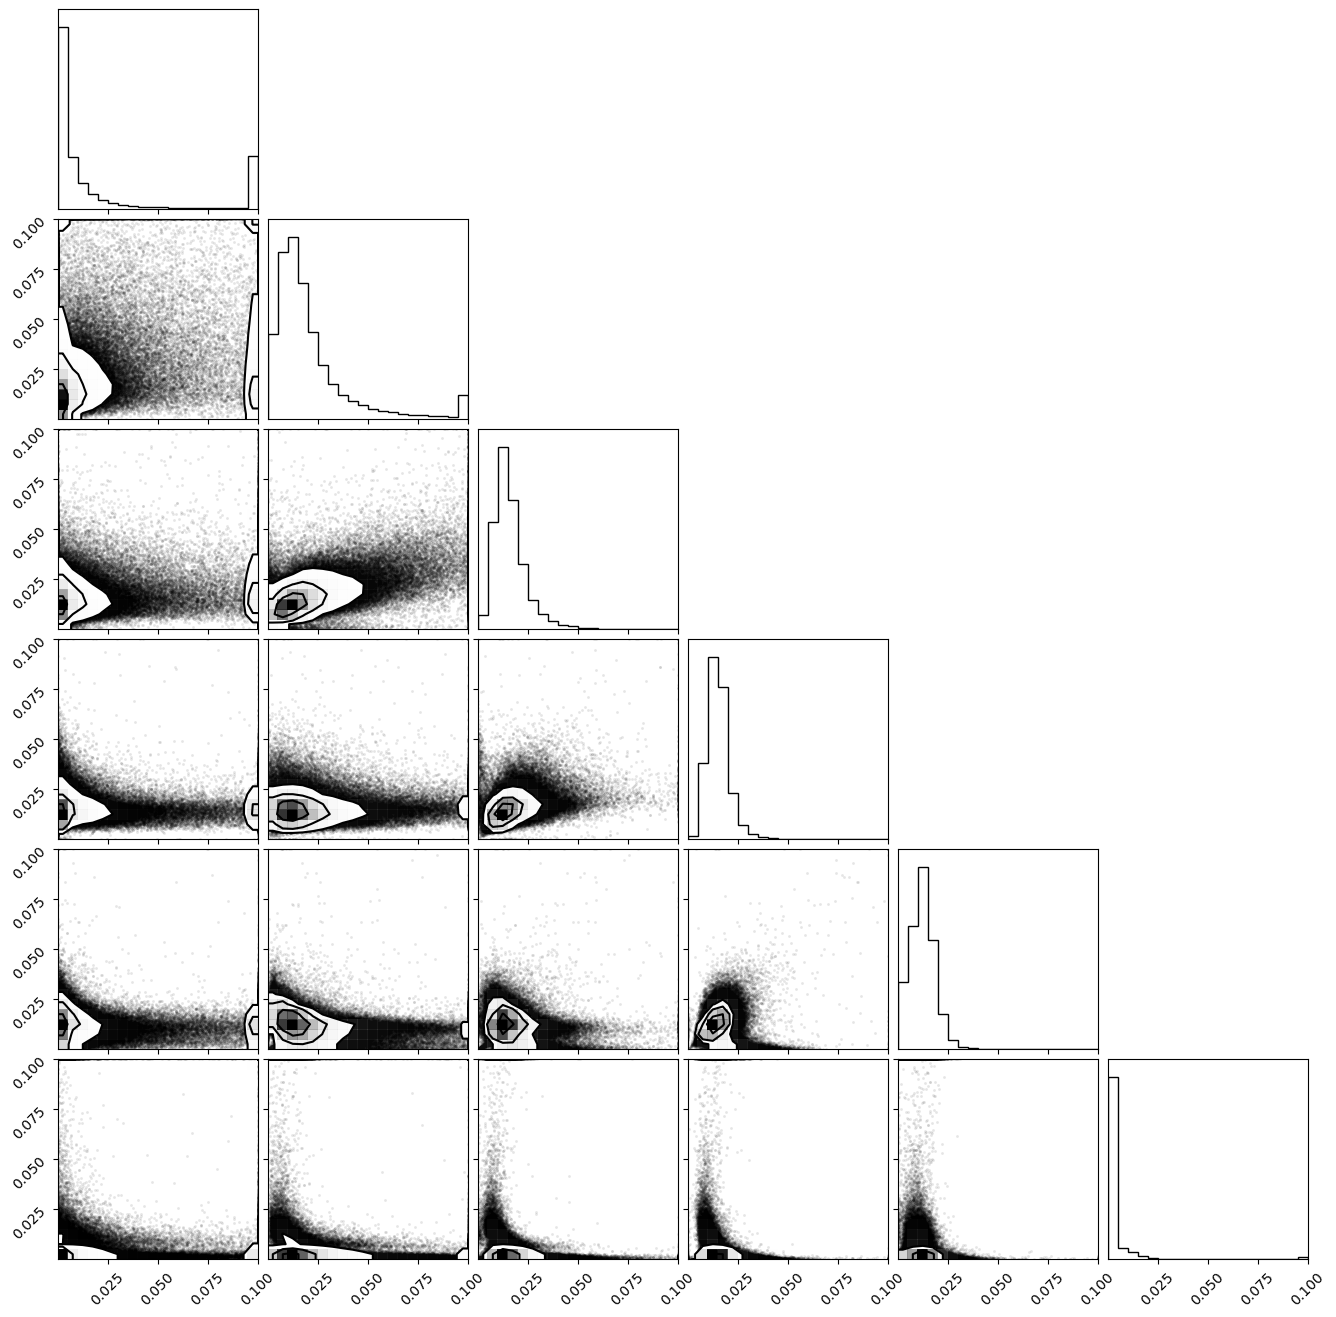

In [212]:
_ = corner.corner(np.nan_to_num(diff_mags.clip(-0.1, 0.1)))

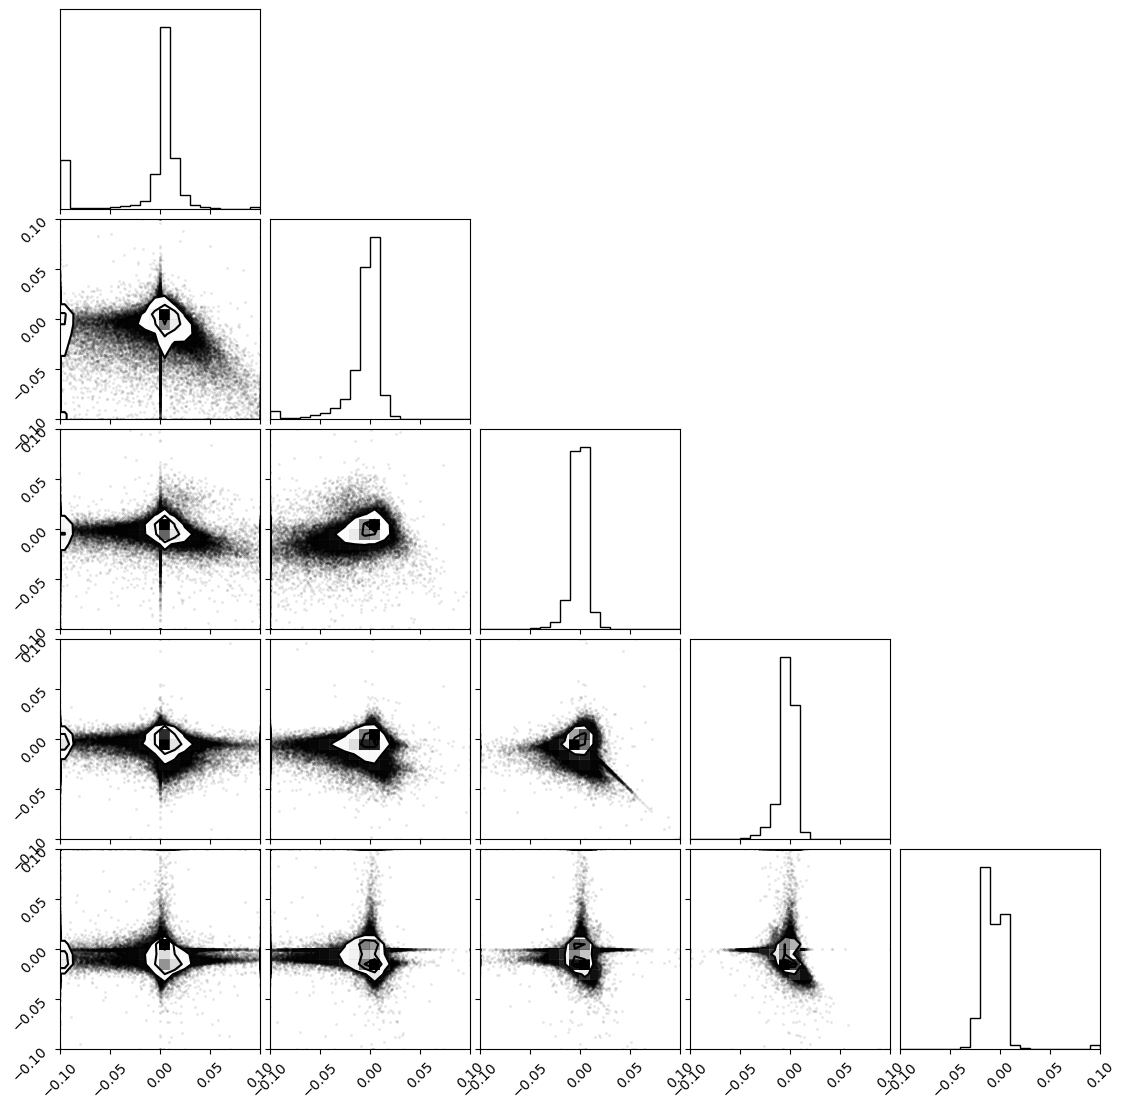

In [214]:
_ = corner.corner(np.nan_to_num(diff_colors).clip(-0.1, 0.1))

In [ ]:

_ = plt.hist(diff_colors[:,1], bins=np.linspace(-0.05, 0.05, 101))

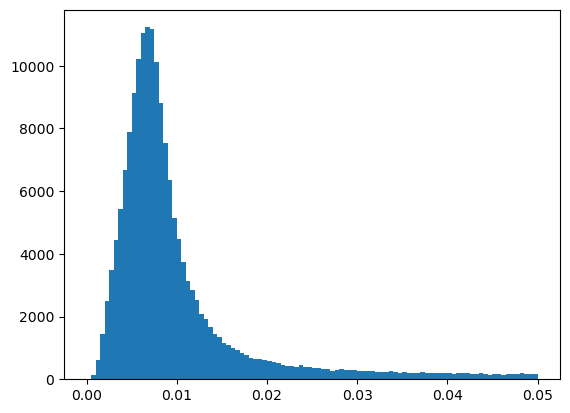

In [87]:
_ = plt.hist(diff_mags.std(axis=1), bins=np.linspace(-0.0, 0.05, 101))

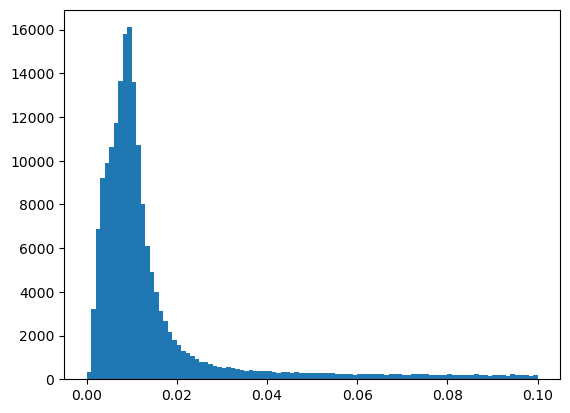

In [88]:
_ = plt.hist(diff_colors.std(axis=1), bins=np.linspace(0., 0.1, 101))

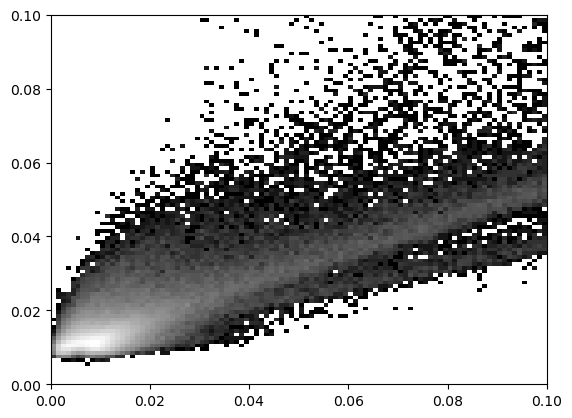

In [89]:
_ = plt.hist2d(diff_colors.std(axis=1), diff_mags.mean(axis=1), bins=(np.linspace(0, 0.1, 101), np.linspace(0., 0.1, 101)), cmap='gray', norm='log')
_ = plt.xlim(0., 0.1)
_ = plt.ylim(0., 0.1)

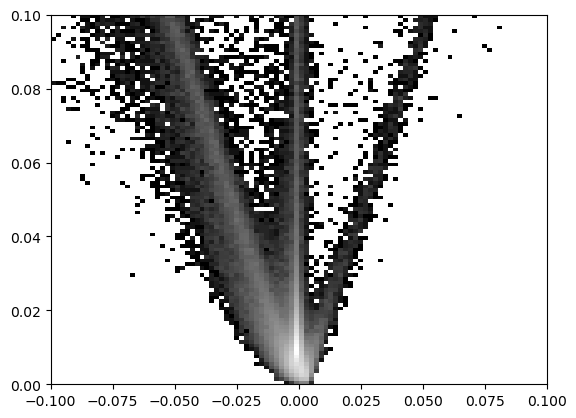

In [90]:
_ = plt.hist2d(diff_colors.mean(axis=1), diff_colors.std(axis=1), bins=(np.linspace(-0.1, 0.1, 101), np.linspace(0., 0.1, 101)), cmap='gray', norm='log')
_ = plt.xlim(-0.1, 0.1)
_ = plt.ylim(0., 0.1)